In [59]:
# 필요한 패키지 import 하기
import os # 환경 변수나 디렉터리, 파일 등의 OS 자원을 제어할 수 있게 해주는 모듈
import cv2 # OpenCV라이브러리 → 컴퓨터 비전 관련 프로그래밍을 쉽게 할 수 있도록 도와주는 라이브러리
import matplotlib.pyplot as plt # 다양한 데이터를 많은 방법으로 도식화 할 수 있도록 하는 라이브러리
import numpy as np # 다차원 배열을 쉽게 처리하고 효율적으로 사용할 수 있도록 하는 라이브러리
import dlib # 이미지 처리 및 기계 학습, 얼굴인식 등을 할 수 있는 c++ 로 개발된 고성능의 라이브러리 


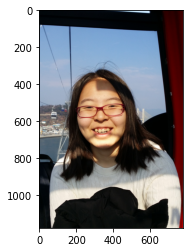

(1179, 778, 3)

In [60]:
# my_image_path = '/aiffel/aiffel/camera_sticker/images/image.png'
# --> 잘 붙여짐
# my_image_path = '/aiffel/aiffel/camera_sticker/images/hana.png' 
# --> 엉뚱한데를 또 얼굴로 인식해서, 스티커가 안 붙여짐
my_image_path = '/aiffel/aiffel/camera_sticker/images/hana2.png' 

# cv2.imread( fileName, flag - 1:COLOR,0: GRAYSCALE, U-1:NCHANGED  ) : return type = numpy.ndarray

img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()              # 출력용 이미지를 따로 보관합니다

# opencv는 예외적으로 BGR(파랑, 녹색, 빨강)을 사용하여 푸른 빛으로 나온다. 
# plt.imshow 이전에 BGR -> RGB로 변경 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb) # 이미지 실제 출력하기 위해 이미지를 올려줌 (원하는 사이즈의 픽셀을 원하는 색으로 채워서 만든 그림이라고 합니다.)
plt.show() # 이미지 실제 출력

img_rgb.shape

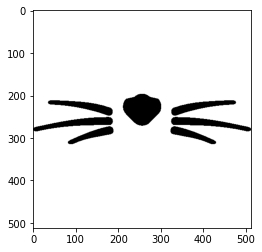

In [61]:
# 스티커 이미지 실제 출력
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png' # 고양이수염 이미지의 경로
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다 // cv2.imread(이미지 경로) → image객체 행렬을 반환
plt.imshow(img_sticker) 
plt.show() 

# 얼굴 검출 face detection (detctor_hog() -> dlib.rectangle)
dlib의 face detector는 HOG(Histogram of Oriented Gradients)와 SVM(Support Vector Machine)을 사용해서 얼굴을 찾는다
HOG : 이미지에서 색상의 변화량을 나타냄
SVM : 선형 분류기

rectangles[[(200, 468) (468, 736)]]
269
269


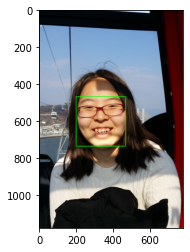

In [62]:

# detector를 선언 : 기본 얼굴 감지기
detector_hog = dlib.get_frontal_face_detector() # 기본 얼굴 감지기를 반환

# detector_hog를 이용해서 얼굴의 bounding box를 추출
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)

# dlib.rectangle객체는 left(), top(), right(), bottom(), height(), width() 등의 멤버 함수를 포함

# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있음
print(dlib_rects)  


for dlib_rect in dlib_rects: # 찾은 얼굴 영역의 좌표
    l = dlib_rect.left() # 왼쪽
    t = dlib_rect.top() # 위쪽
    r = dlib_rect.right() # 오른쪽
    b = dlib_rect.bottom() # 아래쪽
    
    print(dlib_rect.height())
    print(dlib_rect.width())

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA) # 시작점의 좌표와 종료점 좌표로 직각 사각형을 그림

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

# 얼굴 랜드마크 face landmark (dlib.shape_predictor -> dlib.full_object_detection)

 이목구비의 위치를 추론하는 것을 face landmark localization 기술
 face landmark는 detection 의 결과물인 bounding box 로 잘라낸(crop) 얼굴 이미지를 이용
 
 Object keypoint estimation 알고리즘
 1. top-down : bounding box를 찾고 box 내부의 keypoint를 예측
 2. bottom-up : 이미지 전체의 keypoint를 먼저 찾고 point 관계를 이용해 군집화 해서 box 생성

In [63]:
model_path = '/aiffel/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
# 저장한 landmark 모델의 주소를 model_path 변수에 저장
# 68개의 랜드 마크를 가지고 있음

# dlib 라이브러리의 shape_predictor 함수를 이용하여 모델을 불러옴
# return value는 dlib.full_object_detection
landmark_predictor = dlib.shape_predictor(model_path)
    


In [64]:
list_landmarks = []     # 랜드마크의 위치를 저장할 list 생성    
                        # 각 원소는 68개의 랜드마크 위치가 나열된 list 

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
# face landmark 좌표를 저장해둡니다
for dlib_rect in dlib_rects:
    
    # RGB 이미지와 dlib.rectangle을 입력 받아 dlib.full_object_detection 를 반환
    # landmark_predictor는 RGB이미지와 dlib.rectangle를 입력 받고 dlib.full_object_detection를 반환
    # dlib.rectangle: 내부를 예측하는 박스
    # dlib.full_object_detection: 각 구성 요소의 위치와, 이미지 상의 객체의 위치를 나타냄
    points = landmark_predictor(img_rgb, dlib_rect)
    # 모든 landmark의 위치정보를 points 변수에 저장
    
    # 각각의 landmark 위치정보를 (x,y) 형태로 변환하여 list_points 리스트로 저장
    list_points = list( map(lambda p: (p.x, p.y), points.parts()) )
   
    # list_landmarks에 랜드마크 리스트를 저장    
    list_landmarks.append(list_points)
        

# 실제 사용한 이미지에서, 얼굴은 1개이므로, list_landmarks[0]만 사용한다. 
print(len(list_landmarks[0]))


68


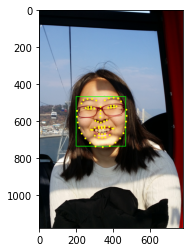

In [65]:
# list_landmarks의 원소가 1개이므로 아래 반복문은 한번만 실행됨
# img_show는 아까 출력용으로 따로 copy해 둔 이미지임 (BGR형식)
for landmark in list_landmarks:
    for point in landmark:
        # cv2.circle: OpenCV의 원을 그리는 함수
        cv2.circle(img_show, point, 5, (0, 255, 255), -1)
            # img_show 이미지 위 각각의 point에
            # 크기가 2이고 (0, 255, 255)색으로 내부가 채워진(-1) 원을 그림
            # (마지막 인수가 자연수라면 그만큼의 두께의 선으로 원이 그려짐)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
    # RGB 이미지로 전환
plt.imshow(img_show_rgb)
    # 이미지를 준비
plt.show()
    # 이미지를 출력

# 스티커의 크기와 위치 조정하기

In [66]:
# zip() : 두 그룹의 데이터를 서로 엮어주는 파이썬의 내장 함수
# dlib_rects와 list_landmarks 데이터를 엮어 주었음
# dlib_rects : 얼굴 영역을 저장하고 있는 값
# → rectangles[[(345, 98) (531, 284)]]
# list_landmarks : 68개의 랜드마크 값 저장(이목구비 위치(x,y))

for dlib_rect, landmark in zip(dlib_rects, list_landmarks): # 얼굴 영역을 저장하고 있는 값과 68개의 랜드마크를 저장하고 있는 값으로 반복문 실행
    print (landmark[33]) # 코끝의 index는 33 입니다  
    print (landmark[51]) # 입윗부분의 index는 51 입니다
    x = landmark[33][0]  # 이미지에서 수염 중앙 부위의 x값
    #y = landmark[33][1] + (landmark[51][1] - landmark[33][1]) //2  # 이미지에서 수염 중앙 부위의 y값- dlib_rect.height()//2 # 이미지에서 코 부위의 y값 - 얼굴 영역의 세로를 차지하는 픽셀의 수//2 → (437, 182-(186+1//2))
    y = landmark[33][1]
    w = dlib_rect.width()
    h = dlib_rect.width()
    w = ((landmark[54][0] -  landmark[48][0]) * 3 )//2
   # h = landmark[51][1] - landmark[33][1]
    
    print (landmark[33][0],landmark[33][1] )
    print (landmark[51][0],landmark[51][1] )
    print (landmark[48][0],landmark[54][0] ) # 입술크기
    print (f'(x,y) : ({x},{y})')
    print (f'(w,h) : ({w},{h})')

    

(334, 609)
(338, 632)
334 609
338 632
281 402
(x,y) : (334,609)
(w,h) : (181,269)


In [67]:
img_sticker = cv2.resize(img_sticker, (w,h)) # 스티커 이미지 조정 → w,h는 얼굴 영역의 가로를 차지하는 픽셀의 수(187) // cv2.resize(image객체 행렬, (가로 길이, 세로 길이))
print (img_sticker.shape) # 사이즈를 조정한 왕관 이미지의 차원 확인

(269, 181, 3)


In [68]:
# x,y,w,h 모두 위에서 반복문 안에서 지정해준 값임
# x는 이미지에서 코 부위의 x값 = 437
# y는 이미지에서 코 부위의 y값 = 89
# w는 얼굴 영역의 가로를 차지하는 픽셀의 수 = 187
# h는 얼굴 영역의 가로를 차지하는 픽셀의 수 = 187

refined_x = x - w // 2 
refined_y = y -h //2
#refined_y = y + h

# 원본 이미지에 스티커 이미지를 추가하기 위해서 x, y 좌표를 조정합니다. 이미지 시작점은 top-left 좌표이기 때문입니다.
# 즉, refined_x, refined_y값에서 왕관 이미지가 시작됨
print (f'(x,y) : ({refined_x},{refined_y})') # 음수 발생 : 이미지 범위를 벗어남
# 우리는 현재 이마 자리에 왕관을 두고 싶은건데, 이마위치 - 왕관 높이를 했더니 이미지의 범위를 초과하여 음수가 나오는 것
# opencv는 ndarray데이터를 사용하는데, ndarray는 음수인덱스에 접근 불가하므로 스티커 이미지를 잘라 줘야 한다.

(x,y) : (244,475)


In [69]:
# 왕관 이미지가 이미지 밖에서 시작하지 않도록 조정이 필요함
# 좌표 순서가 y,x임에 유의한다. (y,x,rgb channel)
# 현재 상황에서는 -y 크기만큼 스티커를 crop 하고, top 의 x좌표와 y 좌표를 각각의 경우에 맞춰 원본 이미지의 경계 값으로 수정하면 아래와 같은 형식으로 나옵니다.
# 음수값 만큼 왕관 이미지(혹은 추후 적용할 스티커 이미지)를 자른다.
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
# 왕관 이미지를 씌우기 위해 왕관 이미지가 시작할 y좌표 값 조정
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :] # refined_y가 -98이므로, img_sticker[98: , :]가 된다. (187, 187, 3)에서 (89, 187, 3)이 됨 (187개 중에서 98개가 잘려나감)
    refined_y = 0

print (f'(x,y) : ({refined_x},{refined_y})')
print (f'(image_sticker x,y) : ({img_sticker.shape[1]}, {img_sticker.shape[0]})')

(x,y) : (244,475)
(image_sticker x,y) : (181, 269)


# 원본 이미지에 스티커 붙이기

In [70]:
# sticker_area는 원본이미지에서 스티커를 적용할 위치를 crop한 이미지 입니다.


sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

print(len(sticker_area))
#print(f'(sticker_area) : ({sticker_area})' )


# 왕관 이미지에서 사용할 부분은 0이 아닌 색이 있는 부분을 사용합니다.
# 왕관 이미지에서 0이 나오는 부분은 흰색이라는 뜻, 즉 이미지가 없다는 소리임.
# 현재 왕관 이미지에서는 왕관과 받침대 밑의 ------ 부분이 됨
# 그렇기 때문에 0인 부분(이미지가 없는 부분)은 제외하고 적용
# sticker_area는 원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지입니다.
# 즉, 왕관 이미지에서 왕관 이미지가 없는 부분(왕관과 받침대 밑의 ------ 부분)은 
# 원본 이미지에서 미리 잘라놓은 sticker_area(스티커 적용할 부분 만큼 원본 이미지에서 자른 이미지)를 
# 적용하고, 나머지 부분은 스티커로 채워주면 됨
# np.where는 조건에 해당하는 인덱스만 찾아서 값을 적용하는 방법이다.
# 아래 코드에서는 img_sticker가 0일 경우(왕관 이미지에서 왕관 부분 제외한 나머지 이미지)에는 
# sticker_area(원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지)를 적용하고,
# 나머지 부분은 img_sticker(왕관 이미지)를 적용한다.

img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker!=0,sticker_area,img_sticker).astype(np.uint8)
print("슝~")

269
슝~


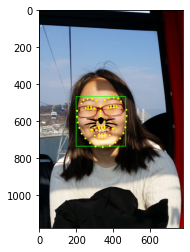

In [71]:
# 수염 이미지를 적용한 이미지를 보여준다.
# 얼굴 영역(7-3)과 랜드마크(7-4)를 미리 적용해놓은 img_show에 왕관 이미지를 덧붙인 이미지가 나오게 된다.)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

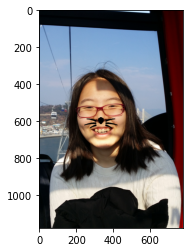

In [72]:
# 위에서 설명했으므로 생략
# 수염 이미지
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
# img_bgr은 7-2에서 rgb로만 적용해놓은 원본 이미지이다. 

img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker!=0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)) # rgb만 적용해놓은 원본 이미지에 왕관 이미지를 덮어 씌운 이미지가 나오게 된다.
plt.show()